# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 3e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 202/202 [03:12<00:00,  1.05it/s]


[INFO] EPOCH: 1/100
Train loss: 0.339523, Test loss: 0.2195, Train IoU: 0.5043, Test IoU: 0.6591, Train Dice: 0.6605, Test Dice: 0.8005
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 2/100
Train loss: 0.190243, Test loss: 0.1714, Train IoU: 0.6810, Test IoU: 0.7269, Train Dice: 0.8098, Test Dice: 0.8486
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.92it/s]


[INFO] EPOCH: 3/100
Train loss: 0.160990, Test loss: 0.1525, Train IoU: 0.7230, Test IoU: 0.7550, Train Dice: 0.8390, Test Dice: 0.8675
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 4/100
Train loss: 0.147474, Test loss: 0.1444, Train IoU: 0.7432, Test IoU: 0.7673, Train Dice: 0.8525, Test Dice: 0.8756
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 5/100
Train loss: 0.139535, Test loss: 0.1377, Train IoU: 0.7554, Test IoU: 0.7777, Train Dice: 0.8605, Test Dice: 0.8823
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 6/100
Train loss: 0.133189, Test loss: 0.1275, Train IoU: 0.7652, Test IoU: 0.7937, Train Dice: 0.8668, Test Dice: 0.8925
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 7/100
Train loss: 0.124666, Test loss: 0.1199, Train IoU: 0.7786, Test IoU: 0.8059, Train Dice: 0.8753, Test Dice: 0.9001
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 8/100
Train loss: 0.119697, Test loss: 0.1154, Train IoU: 0.7865, Test IoU: 0.8129, Train Dice: 0.8803, Test Dice: 0.9046
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 9/100
Train loss: 0.115102, Test loss: 0.1159, Train IoU: 0.7938, Test IoU: 0.8123, Train Dice: 0.8849, Test Dice: 0.9041


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 10/100
Train loss: 0.113234, Test loss: 0.1088, Train IoU: 0.7969, Test IoU: 0.8237, Train Dice: 0.8868, Test Dice: 0.9112
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 11/100
Train loss: 0.102221, Test loss: 0.0944, Train IoU: 0.8147, Test IoU: 0.8473, Train Dice: 0.8978, Test Dice: 0.9256
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 12/100
Train loss: 0.095033, Test loss: 0.0921, Train IoU: 0.8266, Test IoU: 0.8513, Train Dice: 0.9050, Test Dice: 0.9279
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 13/100
Train loss: 0.092418, Test loss: 0.0905, Train IoU: 0.8309, Test IoU: 0.8539, Train Dice: 0.9076, Test Dice: 0.9295
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 14/100
Train loss: 0.090539, Test loss: 0.0879, Train IoU: 0.8341, Test IoU: 0.8583, Train Dice: 0.9095, Test Dice: 0.9321
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 15/100
Train loss: 0.088810, Test loss: 0.0863, Train IoU: 0.8370, Test IoU: 0.8610, Train Dice: 0.9112, Test Dice: 0.9337
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 16/100
Train loss: 0.086735, Test loss: 0.0864, Train IoU: 0.8405, Test IoU: 0.8608, Train Dice: 0.9133, Test Dice: 0.9336


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 17/100
Train loss: 0.085929, Test loss: 0.0838, Train IoU: 0.8419, Test IoU: 0.8652, Train Dice: 0.9141, Test Dice: 0.9362
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 18/100
Train loss: 0.085178, Test loss: 0.0835, Train IoU: 0.8432, Test IoU: 0.8658, Train Dice: 0.9148, Test Dice: 0.9365
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 19/100
Train loss: 0.083471, Test loss: 0.0804, Train IoU: 0.8460, Test IoU: 0.8710, Train Dice: 0.9165, Test Dice: 0.9396
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 20/100
Train loss: 0.081532, Test loss: 0.0769, Train IoU: 0.8493, Test IoU: 0.8771, Train Dice: 0.9185, Test Dice: 0.9431
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.94it/s]


[INFO] EPOCH: 21/100
Train loss: 0.080956, Test loss: 0.0794, Train IoU: 0.8503, Test IoU: 0.8728, Train Dice: 0.9190, Test Dice: 0.9406


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 22/100
Train loss: 0.078889, Test loss: 0.0756, Train IoU: 0.8539, Test IoU: 0.8793, Train Dice: 0.9211, Test Dice: 0.9444
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 23/100
Train loss: 0.077941, Test loss: 0.0751, Train IoU: 0.8555, Test IoU: 0.8803, Train Dice: 0.9221, Test Dice: 0.9449
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 24/100
Train loss: 0.077419, Test loss: 0.0746, Train IoU: 0.8564, Test IoU: 0.8811, Train Dice: 0.9226, Test Dice: 0.9454
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 25/100
Train loss: 0.076727, Test loss: 0.0747, Train IoU: 0.8576, Test IoU: 0.8809, Train Dice: 0.9233, Test Dice: 0.9453


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 26/100
Train loss: 0.076531, Test loss: 0.0736, Train IoU: 0.8579, Test IoU: 0.8828, Train Dice: 0.9235, Test Dice: 0.9464
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 27/100
Train loss: 0.075524, Test loss: 0.0716, Train IoU: 0.8597, Test IoU: 0.8863, Train Dice: 0.9245, Test Dice: 0.9484
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 28/100
Train loss: 0.074923, Test loss: 0.0722, Train IoU: 0.8607, Test IoU: 0.8852, Train Dice: 0.9251, Test Dice: 0.9478


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 29/100
Train loss: 0.074050, Test loss: 0.0715, Train IoU: 0.8622, Test IoU: 0.8865, Train Dice: 0.9259, Test Dice: 0.9485
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 30/100
Train loss: 0.073185, Test loss: 0.0709, Train IoU: 0.8637, Test IoU: 0.8875, Train Dice: 0.9268, Test Dice: 0.9491
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 31/100
Train loss: 0.072458, Test loss: 0.0693, Train IoU: 0.8650, Test IoU: 0.8903, Train Dice: 0.9275, Test Dice: 0.9507
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 32/100
Train loss: 0.070199, Test loss: 0.0658, Train IoU: 0.8689, Test IoU: 0.8964, Train Dice: 0.9298, Test Dice: 0.9542
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 33/100
Train loss: 0.066291, Test loss: 0.0629, Train IoU: 0.8757, Test IoU: 0.9015, Train Dice: 0.9337, Test Dice: 0.9571
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 34/100
Train loss: 0.064660, Test loss: 0.0630, Train IoU: 0.8786, Test IoU: 0.9014, Train Dice: 0.9353, Test Dice: 0.9570


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 35/100
Train loss: 0.062771, Test loss: 0.0595, Train IoU: 0.8819, Test IoU: 0.9076, Train Dice: 0.9372, Test Dice: 0.9605
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 36/100
Train loss: 0.061774, Test loss: 0.0587, Train IoU: 0.8837, Test IoU: 0.9090, Train Dice: 0.9382, Test Dice: 0.9613
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 37/100
Train loss: 0.060802, Test loss: 0.0583, Train IoU: 0.8854, Test IoU: 0.9097, Train Dice: 0.9392, Test Dice: 0.9617
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 38/100
Train loss: 0.059684, Test loss: 0.0569, Train IoU: 0.8874, Test IoU: 0.9123, Train Dice: 0.9403, Test Dice: 0.9631
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 39/100
Train loss: 0.059092, Test loss: 0.0580, Train IoU: 0.8885, Test IoU: 0.9103, Train Dice: 0.9409, Test Dice: 0.9620


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 40/100
Train loss: 0.058136, Test loss: 0.0561, Train IoU: 0.8902, Test IoU: 0.9137, Train Dice: 0.9419, Test Dice: 0.9639
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 41/100
Train loss: 0.057602, Test loss: 0.0557, Train IoU: 0.8911, Test IoU: 0.9145, Train Dice: 0.9424, Test Dice: 0.9643
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 42/100
Train loss: 0.056923, Test loss: 0.0550, Train IoU: 0.8923, Test IoU: 0.9156, Train Dice: 0.9431, Test Dice: 0.9650
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 43/100
Train loss: 0.056851, Test loss: 0.0557, Train IoU: 0.8925, Test IoU: 0.9143, Train Dice: 0.9431, Test Dice: 0.9643


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 44/100
Train loss: 0.055648, Test loss: 0.0531, Train IoU: 0.8946, Test IoU: 0.9190, Train Dice: 0.9444, Test Dice: 0.9669
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:11<00:00,  1.53it/s]


[INFO] EPOCH: 45/100
Train loss: 0.055428, Test loss: 0.0530, Train IoU: 0.8950, Test IoU: 0.9192, Train Dice: 0.9446, Test Dice: 0.9670
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:20<00:00,  1.44it/s]


[INFO] EPOCH: 46/100
Train loss: 0.054980, Test loss: 0.0519, Train IoU: 0.8958, Test IoU: 0.9212, Train Dice: 0.9450, Test Dice: 0.9681
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 47/100
Train loss: 0.054180, Test loss: 0.0530, Train IoU: 0.8973, Test IoU: 0.9194, Train Dice: 0.9458, Test Dice: 0.9670


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 48/100
Train loss: 0.053958, Test loss: 0.0519, Train IoU: 0.8977, Test IoU: 0.9213, Train Dice: 0.9460, Test Dice: 0.9681
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 49/100
Train loss: 0.054153, Test loss: 0.0511, Train IoU: 0.8973, Test IoU: 0.9227, Train Dice: 0.9458, Test Dice: 0.9689
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 50/100
Train loss: 0.053190, Test loss: 0.0515, Train IoU: 0.8990, Test IoU: 0.9220, Train Dice: 0.9468, Test Dice: 0.9685


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 51/100
Train loss: 0.052811, Test loss: 0.0511, Train IoU: 0.8997, Test IoU: 0.9228, Train Dice: 0.9472, Test Dice: 0.9689
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 52/100
Train loss: 0.052788, Test loss: 0.0511, Train IoU: 0.8998, Test IoU: 0.9228, Train Dice: 0.9472, Test Dice: 0.9689
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 53/100
Train loss: 0.052360, Test loss: 0.0501, Train IoU: 0.9005, Test IoU: 0.9245, Train Dice: 0.9476, Test Dice: 0.9699
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 54/100
Train loss: 0.051493, Test loss: 0.0496, Train IoU: 0.9021, Test IoU: 0.9255, Train Dice: 0.9485, Test Dice: 0.9704
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 55/100
Train loss: 0.051069, Test loss: 0.0491, Train IoU: 0.9029, Test IoU: 0.9264, Train Dice: 0.9489, Test Dice: 0.9709
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.94it/s]


[INFO] EPOCH: 56/100
Train loss: 0.051013, Test loss: 0.0489, Train IoU: 0.9030, Test IoU: 0.9267, Train Dice: 0.9490, Test Dice: 0.9711
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 57/100
Train loss: 0.050383, Test loss: 0.0489, Train IoU: 0.9041, Test IoU: 0.9268, Train Dice: 0.9496, Test Dice: 0.9711
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 58/100
Train loss: 0.050170, Test loss: 0.0485, Train IoU: 0.9045, Test IoU: 0.9274, Train Dice: 0.9498, Test Dice: 0.9715
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 59/100
Train loss: 0.050020, Test loss: 0.0493, Train IoU: 0.9048, Test IoU: 0.9259, Train Dice: 0.9500, Test Dice: 0.9707


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 60/100
Train loss: 0.049405, Test loss: 0.0481, Train IoU: 0.9059, Test IoU: 0.9282, Train Dice: 0.9506, Test Dice: 0.9719
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 61/100
Train loss: 0.049190, Test loss: 0.0490, Train IoU: 0.9063, Test IoU: 0.9266, Train Dice: 0.9508, Test Dice: 0.9710


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 62/100
Train loss: 0.050060, Test loss: 0.0477, Train IoU: 0.9047, Test IoU: 0.9288, Train Dice: 0.9499, Test Dice: 0.9723
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 63/100
Train loss: 0.049046, Test loss: 0.0474, Train IoU: 0.9066, Test IoU: 0.9294, Train Dice: 0.9510, Test Dice: 0.9726
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 64/100
Train loss: 0.048545, Test loss: 0.0473, Train IoU: 0.9075, Test IoU: 0.9297, Train Dice: 0.9515, Test Dice: 0.9727
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 65/100
Train loss: 0.048108, Test loss: 0.0465, Train IoU: 0.9083, Test IoU: 0.9312, Train Dice: 0.9519, Test Dice: 0.9735
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 66/100
Train loss: 0.047675, Test loss: 0.0464, Train IoU: 0.9091, Test IoU: 0.9313, Train Dice: 0.9523, Test Dice: 0.9736
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 67/100
Train loss: 0.047821, Test loss: 0.0459, Train IoU: 0.9088, Test IoU: 0.9323, Train Dice: 0.9522, Test Dice: 0.9741
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 68/100
Train loss: 0.047320, Test loss: 0.0461, Train IoU: 0.9097, Test IoU: 0.9319, Train Dice: 0.9527, Test Dice: 0.9739


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 69/100
Train loss: 0.047181, Test loss: 0.0460, Train IoU: 0.9100, Test IoU: 0.9320, Train Dice: 0.9528, Test Dice: 0.9740


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 70/100
Train loss: 0.046857, Test loss: 0.0456, Train IoU: 0.9106, Test IoU: 0.9327, Train Dice: 0.9531, Test Dice: 0.9744
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 71/100
Train loss: 0.046716, Test loss: 0.0457, Train IoU: 0.9108, Test IoU: 0.9325, Train Dice: 0.9533, Test Dice: 0.9743


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 72/100
Train loss: 0.046665, Test loss: 0.0454, Train IoU: 0.9109, Test IoU: 0.9332, Train Dice: 0.9533, Test Dice: 0.9746
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 73/100
Train loss: 0.046780, Test loss: 0.0452, Train IoU: 0.9107, Test IoU: 0.9335, Train Dice: 0.9532, Test Dice: 0.9748
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 74/100
Train loss: 0.045444, Test loss: 0.0390, Train IoU: 0.9132, Test IoU: 0.9449, Train Dice: 0.9546, Test Dice: 0.9810
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 75/100
Train loss: 0.036611, Test loss: 0.0334, Train IoU: 0.9295, Test IoU: 0.9554, Train Dice: 0.9634, Test Dice: 0.9866
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 76/100
Train loss: 0.033779, Test loss: 0.0316, Train IoU: 0.9347, Test IoU: 0.9587, Train Dice: 0.9662, Test Dice: 0.9884
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 77/100
Train loss: 0.032356, Test loss: 0.0310, Train IoU: 0.9374, Test IoU: 0.9599, Train Dice: 0.9676, Test Dice: 0.9890
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 78/100
Train loss: 0.031518, Test loss: 0.0302, Train IoU: 0.9390, Test IoU: 0.9614, Train Dice: 0.9685, Test Dice: 0.9898
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 79/100
Train loss: 0.030592, Test loss: 0.0291, Train IoU: 0.9407, Test IoU: 0.9636, Train Dice: 0.9694, Test Dice: 0.9909
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 80/100
Train loss: 0.029778, Test loss: 0.0290, Train IoU: 0.9423, Test IoU: 0.9637, Train Dice: 0.9702, Test Dice: 0.9910
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 81/100
Train loss: 0.029432, Test loss: 0.0287, Train IoU: 0.9429, Test IoU: 0.9642, Train Dice: 0.9706, Test Dice: 0.9913
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 82/100
Train loss: 0.029118, Test loss: 0.0290, Train IoU: 0.9435, Test IoU: 0.9637, Train Dice: 0.9709, Test Dice: 0.9910


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 83/100
Train loss: 0.028506, Test loss: 0.0280, Train IoU: 0.9447, Test IoU: 0.9656, Train Dice: 0.9715, Test Dice: 0.9920
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 84/100
Train loss: 0.028142, Test loss: 0.0277, Train IoU: 0.9454, Test IoU: 0.9662, Train Dice: 0.9719, Test Dice: 0.9923
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 85/100
Train loss: 0.027907, Test loss: 0.0276, Train IoU: 0.9458, Test IoU: 0.9664, Train Dice: 0.9721, Test Dice: 0.9924
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 86/100
Train loss: 0.027602, Test loss: 0.0268, Train IoU: 0.9464, Test IoU: 0.9678, Train Dice: 0.9724, Test Dice: 0.9932
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 87/100
Train loss: 0.027333, Test loss: 0.0268, Train IoU: 0.9469, Test IoU: 0.9679, Train Dice: 0.9727, Test Dice: 0.9932
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 88/100
Train loss: 0.027302, Test loss: 0.0269, Train IoU: 0.9470, Test IoU: 0.9677, Train Dice: 0.9727, Test Dice: 0.9931


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 89/100
Train loss: 0.026556, Test loss: 0.0265, Train IoU: 0.9484, Test IoU: 0.9685, Train Dice: 0.9734, Test Dice: 0.9935
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 90/100
Train loss: 0.026525, Test loss: 0.0268, Train IoU: 0.9485, Test IoU: 0.9679, Train Dice: 0.9735, Test Dice: 0.9932


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 91/100
Train loss: 0.026053, Test loss: 0.0259, Train IoU: 0.9494, Test IoU: 0.9695, Train Dice: 0.9739, Test Dice: 0.9941
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 92/100
Train loss: 0.026148, Test loss: 0.0258, Train IoU: 0.9492, Test IoU: 0.9698, Train Dice: 0.9739, Test Dice: 0.9942
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 93/100
Train loss: 0.025935, Test loss: 0.0255, Train IoU: 0.9496, Test IoU: 0.9704, Train Dice: 0.9741, Test Dice: 0.9945
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 94/100
Train loss: 0.025452, Test loss: 0.0251, Train IoU: 0.9505, Test IoU: 0.9711, Train Dice: 0.9745, Test Dice: 0.9949
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 95/100
Train loss: 0.025389, Test loss: 0.0253, Train IoU: 0.9506, Test IoU: 0.9707, Train Dice: 0.9746, Test Dice: 0.9947


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 96/100
Train loss: 0.025032, Test loss: 0.0252, Train IoU: 0.9513, Test IoU: 0.9710, Train Dice: 0.9750, Test Dice: 0.9948


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 97/100
Train loss: 0.025261, Test loss: 0.0251, Train IoU: 0.9509, Test IoU: 0.9711, Train Dice: 0.9747, Test Dice: 0.9949
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 98/100
Train loss: 0.024821, Test loss: 0.0244, Train IoU: 0.9517, Test IoU: 0.9724, Train Dice: 0.9752, Test Dice: 0.9956
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 99/100
Train loss: 0.024521, Test loss: 0.0246, Train IoU: 0.9523, Test IoU: 0.9722, Train Dice: 0.9755, Test Dice: 0.9954


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 100/100
Train loss: 0.024401, Test loss: 0.0247, Train IoU: 0.9526, Test IoU: 0.9719, Train Dice: 0.9756, Test Dice: 0.9953
[INFO] total time taken to train the model: 12522.41s
Best IoU is: 0.97243


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

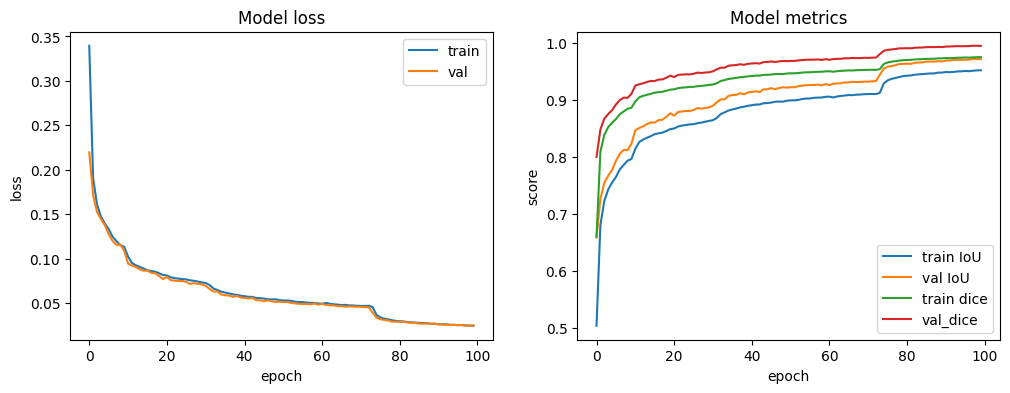

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

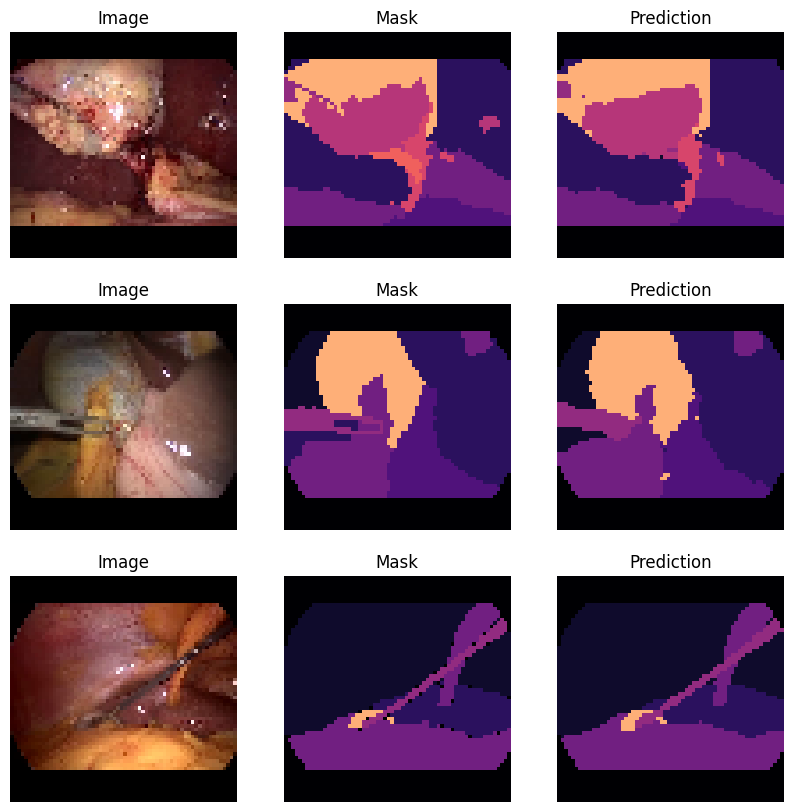

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota